In [1]:
!nvidia-smi

Tue Sep 30 22:40:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.29                 Driver Version: 581.29         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0              9W /   75W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# ======= Cell 1: Imports, Constants & Quick GPU Check =======
import os
import glob
import random
import joblib
import warnings
from pprint import pprint


import numpy as np
import pandas as pd
import cv2
from skimage.feature import hog

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# กำหนด path (ปรับถ้าจำเป็น)
IMG_DIR = "./../data/Right/Image144x144"
ANN_DIR = "./../data/Right/Annotation144x144"
MODEL_SAVE_DIR = "./models_gridsearch_with_radius"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Constants
RESIZED = (144, 144)
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

print("✓ Imports completed")
print(f"✓ Image directory: {IMG_DIR}")
print(f"✓ Annotation directory: {ANN_DIR}")
print(f"✓ Model save directory: {MODEL_SAVE_DIR}")
print(f"✓ Target: cx, cy, radius (3 outputs)")

# --- Quick GPU / environment checks ---
print("\n--- Quick GPU / env checks ---")

# 1) nvidia-smi (works if driver installed)
try:
    smi = os.popen("nvidia-smi -L").read().strip()
    if smi:
        print("nvidia-smi output:")
        print(smi)
    else:
        print("nvidia-smi: no output (either no NVIDIA driver or not available in PATH).")
except Exception as e:
    print("nvidia-smi check failed:", e)

✓ Imports completed
✓ Image directory: ./../data/Right/Image144x144
✓ Annotation directory: ./../data/Right/Annotation144x144
✓ Model save directory: ./models_gridsearch_with_radius
✓ Target: cx, cy, radius (3 outputs)

--- Quick GPU / env checks ---
nvidia-smi output:
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-80adba10-4810-d773-3561-4f9194da87b0)


In [3]:
# ======= Cell 2: Helper Functions =======
def is_number(s):
    """ตรวจสอบว่า string เป็นตัวเลขหรือไม่"""
    try:
        float(s)
        return True
    except:
        return False


def load_data_with_radius(img_dir, ann_dir, size=RESIZED, hog_params=None):
    """
    โหลดภาพและ annotations (cx, cy, r)
    - อ่านเฉพาะภาพที่ไม่ขึ้นต้นด้วย 'annotated_'
    - อ่าน x, y, r จาก .txt
    - คืนค่า labels เป็น (N, 3) แทน (N, 2)
    """
    if hog_params is None:
        hog_params = dict(
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            feature_vector=True,
            block_norm='L2-Hys'
        )

    X, Y_resized, imgs_raw, Y_orig, orig_shapes, filenames = [], [], [], [], [], []
    
    # หาไฟล์ภาพทั้งหมด
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
    imgs = []
    for e in exts:
        imgs += glob.glob(os.path.join(img_dir, e))
    imgs = sorted(imgs)
    
    skipped_annotated = 0
    skipped_no_ann = 0
    loaded = 0
    
    for p in imgs:
        name = os.path.basename(p)
        
        # ข้ามไฟล์ที่ขึ้นต้นด้วย 'annotated_'
        if name.lower().startswith("annotated_"):
            skipped_annotated += 1
            continue

        # หาไฟล์ annotation
        base = os.path.splitext(name)[0]
        annp = os.path.join(ann_dir, base + ".txt")
        
        if not os.path.exists(annp):
            skipped_no_ann += 1
            continue

        # อ่าน annotation (x y r)
        with open(annp, "r", encoding="utf-8") as f:
            content = f.read().strip()
        
        tokens = content.split()
        nums = [float(t) for t in tokens if is_number(t)]
        
        if len(nums) < 3:
            print(f"Warning: {annp} has less than 3 values: {nums}")
            continue
        
        x_raw, y_raw, r_raw = nums[0], nums[1], nums[2]

        # โหลดภาพ (grayscale)
        im = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if im is None:
            print(f"Warning: Cannot read image {p}")
            continue
        
        h, w = im.shape[:2]

        # แปลงพิกัด normalized (0-1) -> pixel (ถ้าจำเป็น)
        if 0.0 <= x_raw <= 1.0 and 0.0 <= y_raw <= 1.0:
            x_px = x_raw * w
            y_px = y_raw * h
            r_px = r_raw * min(w, h)  # normalize radius ตามขนาดภาพ
        else:
            x_px = x_raw
            y_px = y_raw
            r_px = r_raw

        # Preprocessing: CLAHE เพิ่ม contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        im_enhanced = clahe.apply(im)
        
        # Resize และคำนวณ HOG features
        imr = cv2.resize(im_enhanced, size)
        feats = hog(imr, **hog_params)

        # Scale labels -> resized space
        scale_x = size[0] / float(w)
        scale_y = size[1] / float(h)
        scale_r = (scale_x + scale_y) / 2.0  # average scale for radius
        
        x_res = x_px * scale_x
        y_res = y_px * scale_y
        r_res = r_px * scale_r

        imgs_raw.append(im)
        orig_shapes.append((w, h))
        X.append(feats)
        Y_resized.append([x_res, y_res, r_res])  # 3 values
        Y_orig.append([x_px, y_px, r_px])  # 3 values
        filenames.append(name)
        loaded += 1

    print(f"\n📊 Data Loading Summary:")
    print(f"  - Total images found: {len(imgs)}")
    print(f"  - Skipped (annotated_*): {skipped_annotated}")
    print(f"  - Skipped (no annotation): {skipped_no_ann}")
    print(f"  - Successfully loaded: {loaded}")

    if len(X) == 0:
        return np.asarray([]), np.asarray([]), [], np.asarray([]), [], []

    return (np.asarray(X), np.asarray(Y_resized), imgs_raw, 
            np.asarray(Y_orig), orig_shapes, filenames)


def custom_scorer_3d(y_true, y_pred):
    """
    Custom scorer สำหรับ 3D output (cx, cy, r)
    - คำนวณ Euclidean distance สำหรับ (cx, cy)
    - เพิ่ม penalty จาก radius error
    - คืนค่า negative เพราะ GridSearch จะ maximize
    """
    # Euclidean distance for center (cx, cy)
    center_dist = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + 
                          (y_true[:, 1] - y_pred[:, 1])**2)
    
    # Absolute error for radius
    radius_error = np.abs(y_true[:, 2] - y_pred[:, 2])
    
    # Combined score: weighted sum
    score = center_dist.mean() + 0.5 * radius_error.mean()
    
    return -score  # negative เพราะ GridSearch maximize


print("✓ Helper functions defined")

✓ Helper functions defined


In [4]:
# ======= Cell 3: Load Data =======
print("Loading data with radius...")
X, Y_resized, imgs_raw, Y_orig, orig_shapes, filenames = load_data_with_radius(
    IMG_DIR, ANN_DIR, size=RESIZED
)

if len(X) == 0:
    print("❌ No data loaded! Please check your paths.")
else:
    print(f"\n✓ Data loaded successfully:")
    print(f"  - Total samples: {X.shape[0]}")
    print(f"  - Feature dimension: {X.shape[1]}")
    print(f"  - Label shape: {Y_resized.shape} (cx, cy, r)")
    print(f"  - Image size: {RESIZED}")
    
    # แสดงสถิติของ labels
    print(f"\n📈 Label Statistics (Original Space):")
    print(f"  - X range: [{Y_orig[:, 0].min():.2f}, {Y_orig[:, 0].max():.2f}], mean: {Y_orig[:, 0].mean():.2f}")
    print(f"  - Y range: [{Y_orig[:, 1].min():.2f}, {Y_orig[:, 1].max():.2f}], mean: {Y_orig[:, 1].mean():.2f}")
    print(f"  - R range: [{Y_orig[:, 2].min():.2f}, {Y_orig[:, 2].max():.2f}], mean: {Y_orig[:, 2].mean():.2f}")

Loading data with radius...

📊 Data Loading Summary:
  - Total images found: 11108
  - Skipped (annotated_*): 5554
  - Skipped (no annotation): 0
  - Successfully loaded: 5554

✓ Data loaded successfully:
  - Total samples: 5554
  - Feature dimension: 10404
  - Label shape: (5554, 3) (cx, cy, r)
  - Image size: (144, 144)

📈 Label Statistics (Original Space):
  - X range: [11.32, 131.78], mean: 71.54
  - Y range: [38.57, 94.58], mean: 62.75
  - R range: [20.33, 55.32], mean: 31.78


In [5]:
# ======= Cell 4: Train-Test Split =======
# สร้าง indices เพื่อ track ภาพต้นฉบับ
indices = np.arange(len(X))

X_train, X_test, y_train_res, y_test_res, y_train_orig, y_test_orig, \
shapes_train, shapes_test, idx_train, idx_test, files_train, files_test = \
    train_test_split(
        X, Y_resized, Y_orig, orig_shapes, indices, filenames,
        test_size=0.1, random_state=RANDOM_STATE
    )

print(f"\n✓ Data split completed:")
print(f"  - Train samples: {X_train.shape[0]}")
print(f"  - Test samples: {X_test.shape[0]}")
print(f"  - Train/Test ratio: {len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")


✓ Data split completed:
  - Train samples: 4998
  - Test samples: 556
  - Train/Test ratio: 90.0% / 10.0%


In [6]:
# ======= Cell 6: Evaluation Functions =======
def resize_preds_to_orig(preds_resized, orig_shapes, size=RESIZED):
    """แปลง predictions จาก resized space -> original pixel space"""
    out = []
    for i, p in enumerate(preds_resized):
        w, h = orig_shapes[i]
        scale_x_back = w / float(size[0])
        scale_y_back = h / float(size[1])
        scale_r_back = (scale_x_back + scale_y_back) / 2.0
        
        out.append([
            p[0] * scale_x_back,  # x
            p[1] * scale_y_back,  # y
            p[2] * scale_r_back   # r
        ])
    return np.asarray(out)


def evaluate_predictions_3d(y_true_orig, y_pred_orig):
    """คำนวณ metrics สำหรับ (cx, cy, r)"""
    # Metrics สำหรับ center (cx, cy)
    r2_x = r2_score(y_true_orig[:, 0], y_pred_orig[:, 0])
    r2_y = r2_score(y_true_orig[:, 1], y_pred_orig[:, 1])
    r2_center = (r2_x + r2_y) / 2.0
    
    mae_x = mean_absolute_error(y_true_orig[:, 0], y_pred_orig[:, 0])
    mae_y = mean_absolute_error(y_true_orig[:, 1], y_pred_orig[:, 1])
    mae_center = (mae_x + mae_y) / 2.0
    
    # Euclidean distance for center
    center_euclid = np.sqrt((y_true_orig[:, 0] - y_pred_orig[:, 0])**2 + 
                            (y_true_orig[:, 1] - y_pred_orig[:, 1])**2)
    
    # Metrics สำหรับ radius
    r2_r = r2_score(y_true_orig[:, 2], y_pred_orig[:, 2])
    mae_r = mean_absolute_error(y_true_orig[:, 2], y_pred_orig[:, 2])
    mse_r = mean_squared_error(y_true_orig[:, 2], y_pred_orig[:, 2])
    
    # Overall metrics
    mae_all = mean_absolute_error(y_true_orig, y_pred_orig)
    mse_all = mean_squared_error(y_true_orig, y_pred_orig)
    
    return {
        # Center metrics
        'r2_x': r2_x,
        'r2_y': r2_y,
        'r2_center': r2_center,
        'mae_x': mae_x,
        'mae_y': mae_y,
        'mae_center': mae_center,
        'euclid_mean': center_euclid.mean(),
        'euclid_std': center_euclid.std(),
        'euclid_median': np.median(center_euclid),
        'euclid_max': center_euclid.max(),
        
        # Radius metrics
        'r2_r': r2_r,
        'mae_r': mae_r,
        'rmse_r': np.sqrt(mse_r),
        
        # Overall metrics
        'mae_all': mae_all,
        'rmse_all': np.sqrt(mse_all),
        'r2_mean': (r2_x + r2_y + r2_r) / 3.0
    }


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [7]:
# ===== RandomForest =====
param_dist_rf = {
    'n_estimators': randint(200, 600),         
    'max_depth': [20, 30, None],               
    'min_samples_split': randint(2, 11),       
    'min_samples_leaf': randint(1, 5),         
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1)

# RandomizedSearchCV
rand_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_rf,
    n_iter=1,                     # ลองสุ่ม 30 ครั้ง (ปรับได้: ยิ่งมากยิ่งแม่นแต่ช้าลง)
    cv=5,                          # หรือจะใส่ kf เหมือนเดิมก็ได้
    scoring=make_scorer(custom_scorer_3d, greater_is_better=True),
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

rand_rf.fit(X_train, y_train_res)

base_name = "RandomForest_best_random.joblib"
model_path = os.path.join(MODEL_SAVE_DIR, base_name)
i = 1
while os.path.exists(model_path):
    model_path = os.path.join(MODEL_SAVE_DIR, f"RandomForest_best_random_{i}.joblib")
    i += 1

# บันทึก
best_rf = rand_rf.best_estimator_
joblib.dump(best_rf, model_path)

print(f"Best RF params (RandomSearch): {rand_rf.best_params_}")
print(f"Best RF CV score: {rand_rf.best_score_}")
print(f"✓ Model saved to: {model_path}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best RF params (RandomSearch): {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 388}
Best RF CV score: -9.39704061388091
✓ Model saved to: ./models_gridsearch_with_radius\RandomForest_best_random_2.joblib


In [9]:
param_dist_kn = {
    'kneighborsregressor__n_neighbors': [3, 5, 7, 10, 15],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__p': [1, 2],
    'kneighborsregressor__leaf_size': [20, 30, 50]
}

kn_model = KNeighborsRegressor(n_jobs=1)
pipeline_kn = make_pipeline(StandardScaler(), kn_model)

rand_kn = RandomizedSearchCV(
    pipeline_kn,
    param_distributions=param_dist_kn,
    n_iter=1,   # เลือก 20 random combinations จาก 60 → เร็วขึ้น 3 เท่า
    cv=5,
    scoring=make_scorer(custom_scorer_3d, greater_is_better=True),
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

rand_kn.fit(X_train, y_train_res)

base_name = "KNeighbors_best_random.joblib"
model_path = os.path.join(MODEL_SAVE_DIR, base_name)
i = 1
while os.path.exists(model_path):
    model_path = os.path.join(MODEL_SAVE_DIR, f"KNeighbors_best_random_{i}.joblib")
    i += 1

best_kn = rand_kn.best_estimator_
joblib.dump(best_kn, model_path)

print("Best KNN params (Randomized):", rand_kn.best_params_)
print("Best KNN CV score (Randomized):", rand_kn.best_score_)
print(f"✓ Model saved to: {model_path}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [ ]:
param_dist_svr = {
    'multioutputregressor__estimator__C': [1.0, 10.0, 100.0],
    'multioutputregressor__estimator__epsilon': [0.1, 0.2, 0.5],
    'multioutputregressor__estimator__kernel': ['rbf', 'linear'],
    'multioutputregressor__estimator__gamma': ['scale', 'auto']
}

svr_model = MultiOutputRegressor(SVR())
pipeline_svr = make_pipeline(StandardScaler(), svr_model)

rand_svr = RandomizedSearchCV(
    pipeline_svr,
    param_distributions=param_dist_svr,
    n_iter=1,   # เลือก 20 ชุดจาก 36 → เร็วขึ้น ~2x
    cv=5,
    scoring=make_scorer(custom_scorer_3d, greater_is_better=True),
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

print("RandomizedSearch (SVR) start...")
rand_svr.fit(X_train, y_train_res)

# บันทึก best estimator
base_name = "SVR_best_random.joblib"
model_path = os.path.join(MODEL_SAVE_DIR, base_name)
i = 1
while os.path.exists(model_path):
    model_path = os.path.join(MODEL_SAVE_DIR, f"SVR_best_random_{i}.joblib")
    i += 1

best_svr = rand_svr.best_estimator_
joblib.dump(best_svr, model_path)

print("Best SVR params (Randomized):", rand_svr.best_params_)
print("Best SVR CV score (Randomized):", rand_svr.best_score_)
print(f"✓ Model saved to: {model_path}")

In [ ]:
# ===== MLP =====
param_dist_mlp = {
    'mlpregressor__hidden_layer_sizes': [(128,), (128, 64), (128, 64, 32)],
    'mlpregressor__activation': ['relu', 'tanh'],
    'mlpregressor__alpha': [0.0001, 0.001],
    'mlpregressor__learning_rate': ['adaptive'],
    'mlpregressor__learning_rate_init': [0.001, 0.01]
}

mlp_model = MLPRegressor(random_state=RANDOM_STATE, max_iter=1000, early_stopping=True)
pipeline_mlp = make_pipeline(StandardScaler(), mlp_model)

rand_mlp = RandomizedSearchCV(
    pipeline_mlp,
    param_distributions=param_dist_mlp,
    n_iter=1,   # สุ่ม 15 combinations จาก 24 → เร็วขึ้น แต่ยังครอบคลุม
    cv=5,
    scoring=make_scorer(custom_scorer_3d, greater_is_better=True),
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    return_train_score=True
)

print("RandomizedSearch (MLP) start...")
rand_mlp.fit(X_train, y_train_res)

# บันทึก best estimator
base_name = "MLP_best_random.joblib"
model_path = os.path.join(MODEL_SAVE_DIR, base_name)
i = 1
while os.path.exists(model_path):
    model_path = os.path.join(MODEL_SAVE_DIR, f"MLP_best_random_{i}.joblib")
    i += 1

best_mlp = rand_mlp.best_estimator_
joblib.dump(best_mlp, model_path)

print("Best MLP params (Randomized):", rand_mlp.best_params_)
print("Best MLP CV score (Randomized):", rand_mlp.best_score_)
print(f"✓ Model saved to: {model_path}")


In [10]:
results_list = []
predictions_dict = {}
best_models = {}

# หาไฟล์โมเดลที่บันทึกแล้ว
model_files = glob.glob(os.path.join(MODEL_SAVE_DIR, "*.joblib"))

for model_path in model_files:
    model_name = os.path.basename(model_path).replace(".joblib", "")
    print(f"\n🔄 Loading model: {model_name}")
    
    # โหลดโมเดล
    model = joblib.load(model_path)
    best_models[model_name] = model
    
    # ทำการทำนาย
    y_pred_res = model.predict(X_test)
    y_pred_orig = resize_preds_to_orig(y_pred_res, shapes_test, size=RESIZED)
    predictions_dict[model_name] = {'pred_res': y_pred_res, 'pred_orig': y_pred_orig}
    
    # ประเมินผลลัพธ์
    metrics = evaluate_predictions_3d(y_test_orig, y_pred_orig)
    metrics['model'] = model_name
    metrics['n_train'] = len(X_train)
    metrics['n_test'] = len(X_test)
    
    # ถ้าโมเดลนี้ทำ GridSearchCV ไว้ จะบันทึก cv_score ได้
    if hasattr(model, 'best_score_'):
        metrics['cv_score'] = model.best_score_ 
    else:
     metrics['cv_score'] = None
    
    results_list.append(metrics)



🔄 Loading model: RandomForest_best

🔄 Loading model: RandomForest_best_random

🔄 Loading model: RandomForest_best_random_1

🔄 Loading model: RandomForest_best_random_2


In [13]:
# ======= Cell 8: Summary Results =======
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('euclid_mean')

print("\n📊 FINAL RESULTS SUMMARY")
print("="*120)
print(results_df[[
    'model', 'euclid_mean', 'euclid_std', 'mae_center', 'mae_r', 
    'r2_center', 'r2_r', 'r2_mean', 'cv_score'
]].to_string(index=False))
print("="*120)

# บันทึกผลลัพธ์
results_path = os.path.join(MODEL_SAVE_DIR, 'grid_search_results_3d.csv')
results_df.to_csv(results_path, index=False)
print(f"\n✓ Results saved: {results_path}")

# แสดงโมเดลที่ดีที่สุด
best_model_name = results_df.iloc[0]['model']
best_metrics = results_df.iloc[0]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print("="*80)
print(f"CENTER PREDICTION:")
print(f"  - Euclidean Distance: {best_metrics['euclid_mean']:.4f} ± {best_metrics['euclid_std']:.4f} px")
print(f"  - Median Error: {best_metrics['euclid_median']:.4f} px")
print(f"  - Max Error: {best_metrics['euclid_max']:.4f} px")
print(f"  - MAE: {best_metrics['mae_center']:.4f} px (X: {best_metrics['mae_x']:.4f}, Y: {best_metrics['mae_y']:.4f})")
print(f"  - R²: {best_metrics['r2_center']:.4f} (X: {best_metrics['r2_x']:.4f}, Y: {best_metrics['r2_y']:.4f})")
print(f"\nRADIUS PREDICTION:")
print(f"  - MAE: {best_metrics['mae_r']:.4f} px")
print(f"  - RMSE: {best_metrics['rmse_r']:.4f} px")
print(f"  - R²: {best_metrics['r2_r']:.4f}")
print(f"\nOVERALL:")
print(f"  - Mean R²: {best_metrics['r2_mean']:.4f}")
print("="*80)


📊 FINAL RESULTS SUMMARY
                     model  euclid_mean  euclid_std  mae_center    mae_r  r2_center     r2_r  r2_mean cv_score
         RandomForest_best     5.579383    5.122065    3.477363 1.957126   0.703857 0.690580 0.699431     None
  RandomForest_best_random     5.948394    5.276308    3.704432 2.163464   0.644815 0.612794 0.634142     None
RandomForest_best_random_1     7.773870    6.105903    4.784181 2.315209   0.530020 0.567789 0.542610     None
RandomForest_best_random_2     7.773870    6.105903    4.784181 2.315209   0.530020 0.567789 0.542610     None

✓ Results saved: ./models_gridsearch_with_radius\grid_search_results_3d.csv

🏆 BEST MODEL: RandomForest_best
CENTER PREDICTION:
  - Euclidean Distance: 5.5794 ± 5.1221 px
  - Median Error: 3.9964 px
  - Max Error: 43.5668 px
  - MAE: 3.4774 px (X: 4.2804, Y: 2.6743)
  - R²: 0.7039 (X: 0.8042, Y: 0.6035)

RADIUS PREDICTION:
  - MAE: 1.9571 px
  - RMSE: 2.5304 px
  - R²: 0.6906

OVERALL:
  - Mean R²: 0.6994



🖼️  Visualizing predictions for: RandomForest_best


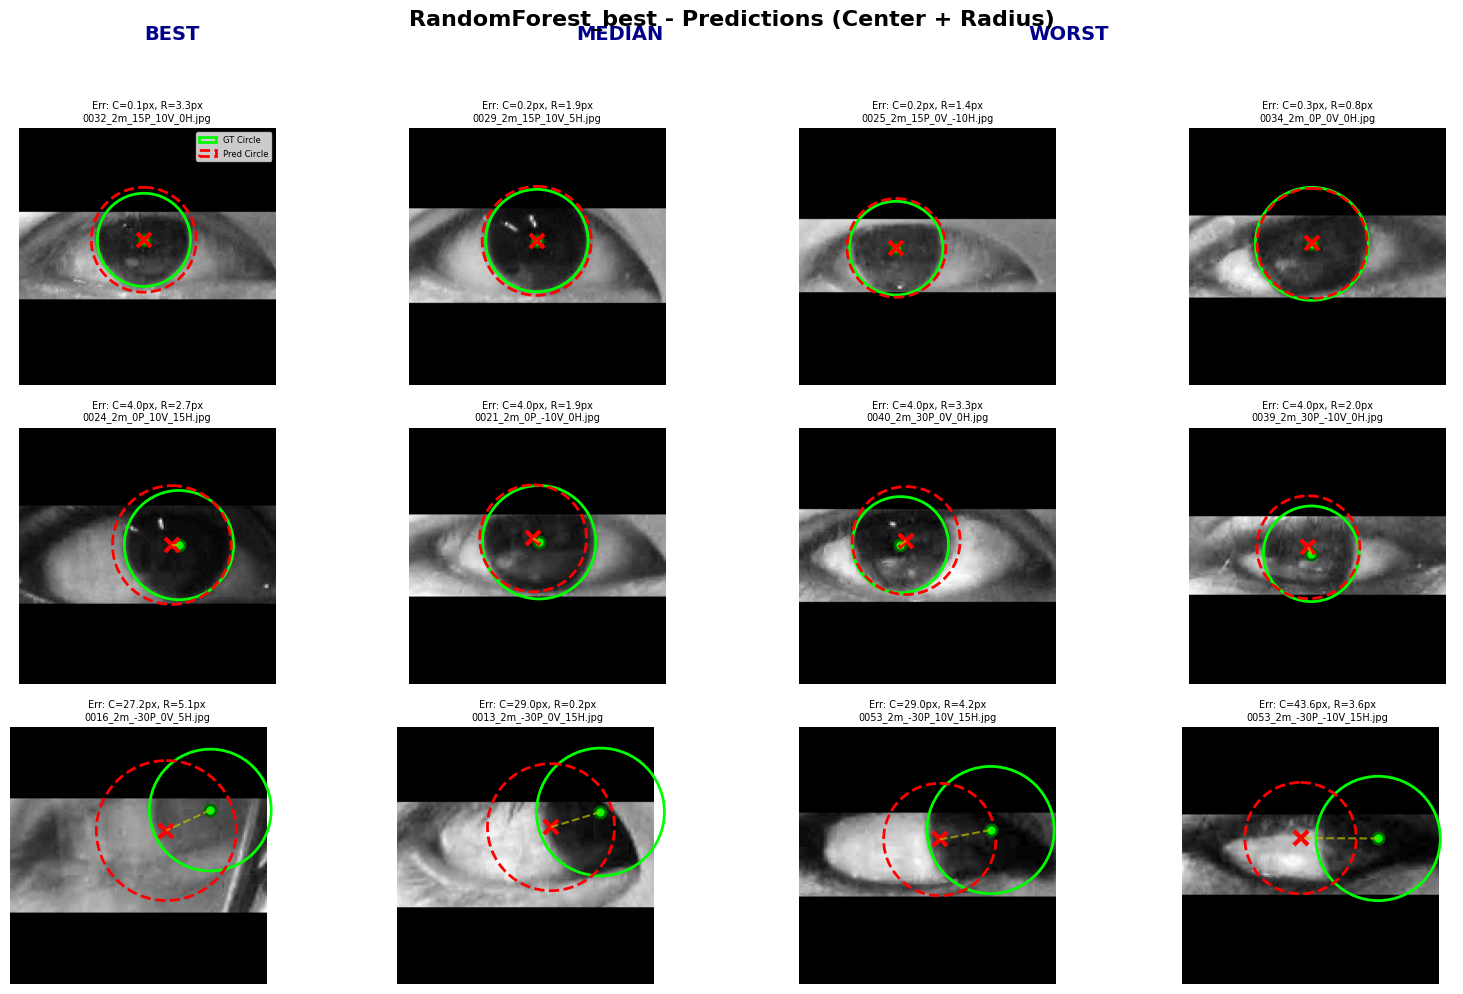

✓ Visualization saved


In [14]:
# ======= Cell 9: Visualize Predictions with Circle =======
def plot_predictions_with_circle(model_name, y_pred_orig, n_samples=12):
    """แสดงตัวอย่าง predictions พร้อมวงกลม radius"""
    # คำนวณ center errors
    center_errors = np.sqrt((y_test_orig[:, 0] - y_pred_orig[:, 0])**2 + 
                           (y_test_orig[:, 1] - y_pred_orig[:, 1])**2)
    
    # คำนวณ radius errors
    radius_errors = np.abs(y_test_orig[:, 2] - y_pred_orig[:, 2])
    
    # เรียงตาม center error
    sorted_idx = np.argsort(center_errors)
    
    # เลือกตัวอย่าง: best, median, worst
    n_best = n_samples // 3
    n_med = n_samples // 3
    n_worst = n_samples - n_best - n_med
    
    sample_idx = np.concatenate([
        sorted_idx[:n_best],
        sorted_idx[len(sorted_idx)//2 - n_med//2 : len(sorted_idx)//2 + n_med//2],
        sorted_idx[-n_worst:]
    ])
    
    fig, axes = plt.subplots(3, n_samples//3, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_idx):
        test_idx = idx_test[idx]
        img = imgs_raw[test_idx]
        
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        
        # Ground Truth (สีเขียว)
        gt_cx, gt_cy, gt_r = y_test_orig[idx]
        circle_gt = plt.Circle((gt_cx, gt_cy), gt_r, color='lime', 
                              fill=False, linewidth=2, label='GT Circle')
        ax.add_patch(circle_gt)
        ax.plot(gt_cx, gt_cy, 'go', markersize=8, markerfacecolor='lime', 
               markeredgewidth=2, markeredgecolor='darkgreen')
        
        # Prediction (สีแดง)
        pred_cx, pred_cy, pred_r = y_pred_orig[idx]
        circle_pred = plt.Circle((pred_cx, pred_cy), pred_r, color='red', 
                                fill=False, linewidth=2, linestyle='--', label='Pred Circle')
        ax.add_patch(circle_pred)
        ax.plot(pred_cx, pred_cy, 'rx', markersize=10, markeredgewidth=3)
        
        # วาดเส้นเชื่อม center
        ax.plot([gt_cx, pred_cx], [gt_cy, pred_cy], 'y--', linewidth=1.5, alpha=0.7)
        
        center_err = center_errors[idx]
        radius_err = radius_errors[idx]
        
        ax.set_title(f'Err: C={center_err:.1f}px, R={radius_err:.1f}px\n{files_test[idx][:25]}', 
                    fontsize=7)
        ax.axis('off')
        
        if i == 0:
            ax.legend(loc='upper right', fontsize=6)
    
    category_labels = ['BEST', 'MEDIAN', 'WORST']
    for i, label in enumerate(category_labels):
        fig.text(0.15 + i*0.28, 0.96, label, ha='center', fontsize=14, 
                fontweight='bold', color='darkblue')
    
    plt.suptitle(f'{model_name} - Predictions (Center + Radius)', 
                fontsize=16, fontweight='bold', y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(MODEL_SAVE_DIR, f'{model_name}_predictions_with_circle.png'), 
               dpi=150, bbox_inches='tight')
    plt.show()


# Plot สำหรับโมเดลที่ดีที่สุด
print(f"\n🖼️  Visualizing predictions for: {best_model_name}")
plot_predictions_with_circle(best_model_name, predictions_dict[best_model_name]['pred_orig'], n_samples=12)

print("✓ Visualization saved")

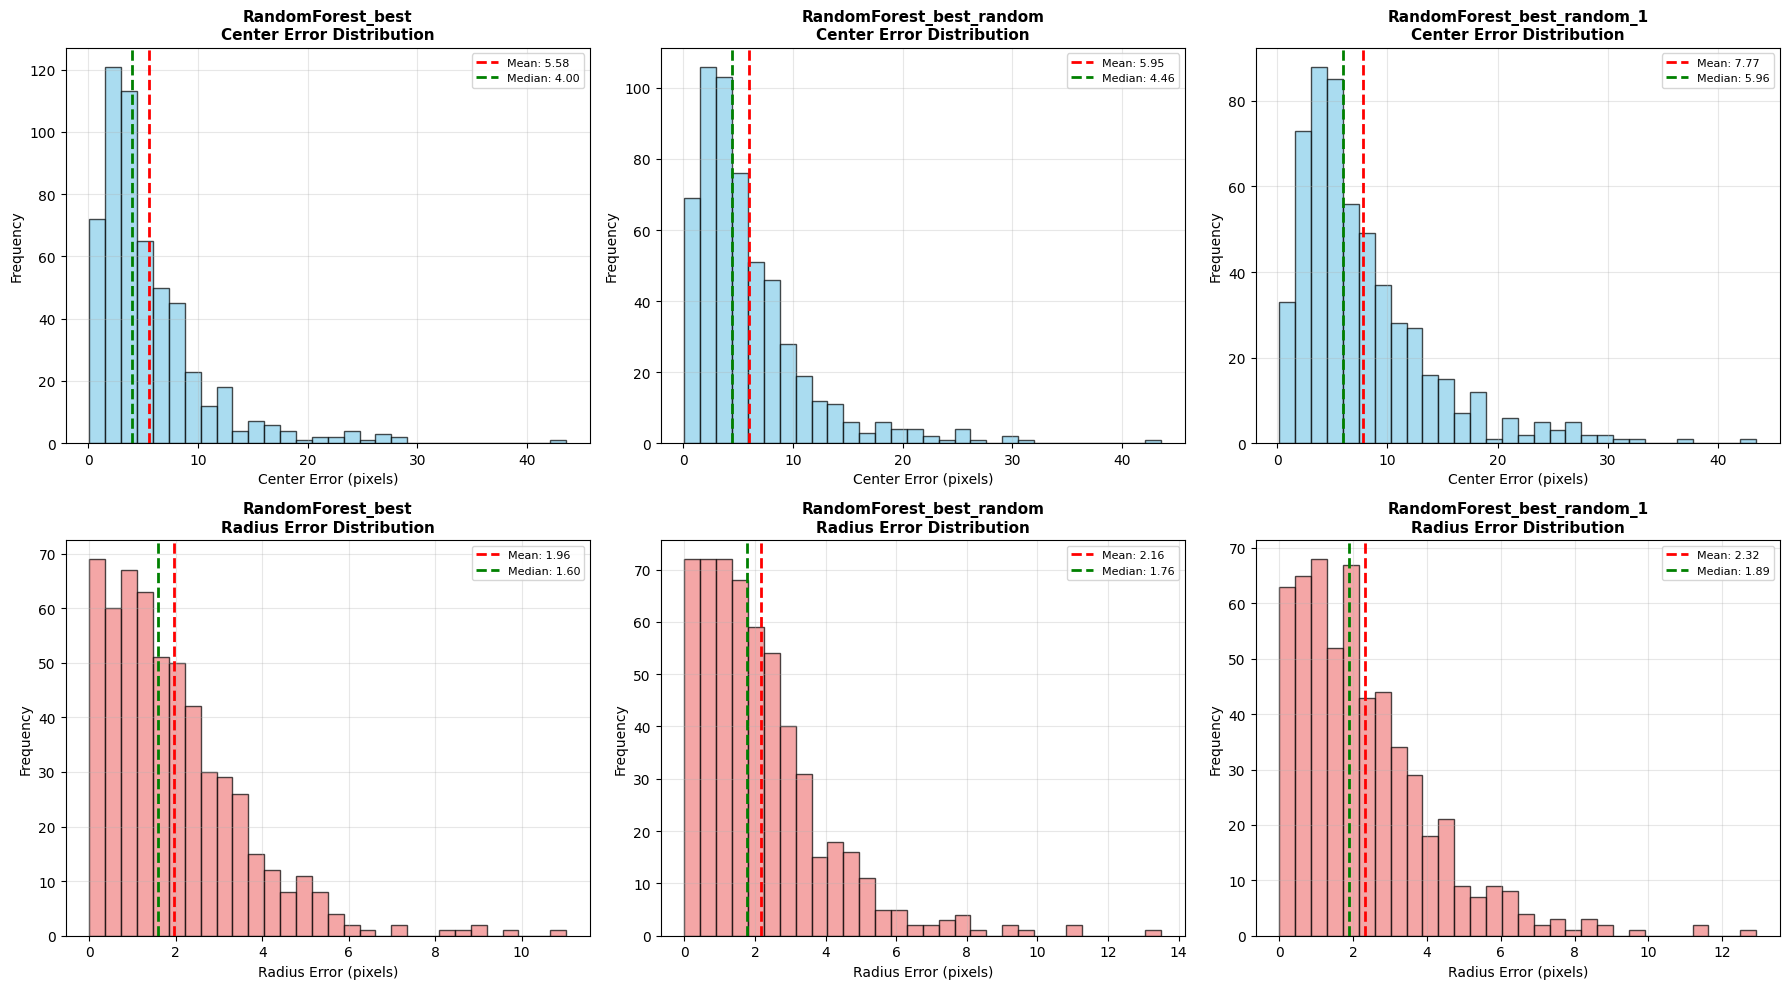

✓ Error distribution plots saved


In [15]:
# ======= Cell 10: Error Distribution Analysis =======
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, model_name in enumerate(results_df['model'].values[:3]):
    y_pred_orig = predictions_dict[model_name]['pred_orig']
    
    # Center errors
    center_errors = np.sqrt((y_test_orig[:, 0] - y_pred_orig[:, 0])**2 + 
                           (y_test_orig[:, 1] - y_pred_orig[:, 1])**2)
    
    # Radius errors
    radius_errors = np.abs(y_test_orig[:, 2] - y_pred_orig[:, 2])
    
    # Plot center errors
    ax1 = axes[0, idx]
    ax1.hist(center_errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(center_errors.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {center_errors.mean():.2f}')
    ax1.axvline(np.median(center_errors), color='green', linestyle='--', linewidth=2, 
               label=f'Median: {np.median(center_errors):.2f}')
    ax1.set_xlabel('Center Error (pixels)', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.set_title(f'{model_name}\nCenter Error Distribution', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot radius errors
    ax2 = axes[1, idx]
    ax2.hist(radius_errors, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.axvline(radius_errors.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {radius_errors.mean():.2f}')
    ax2.axvline(np.median(radius_errors), color='green', linestyle='--', linewidth=2, 
               label=f'Median: {np.median(radius_errors):.2f}')
    ax2.set_xlabel('Radius Error (pixels)', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.set_title(f'{model_name}\nRadius Error Distribution', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'error_distributions_3d.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Error distribution plots saved")

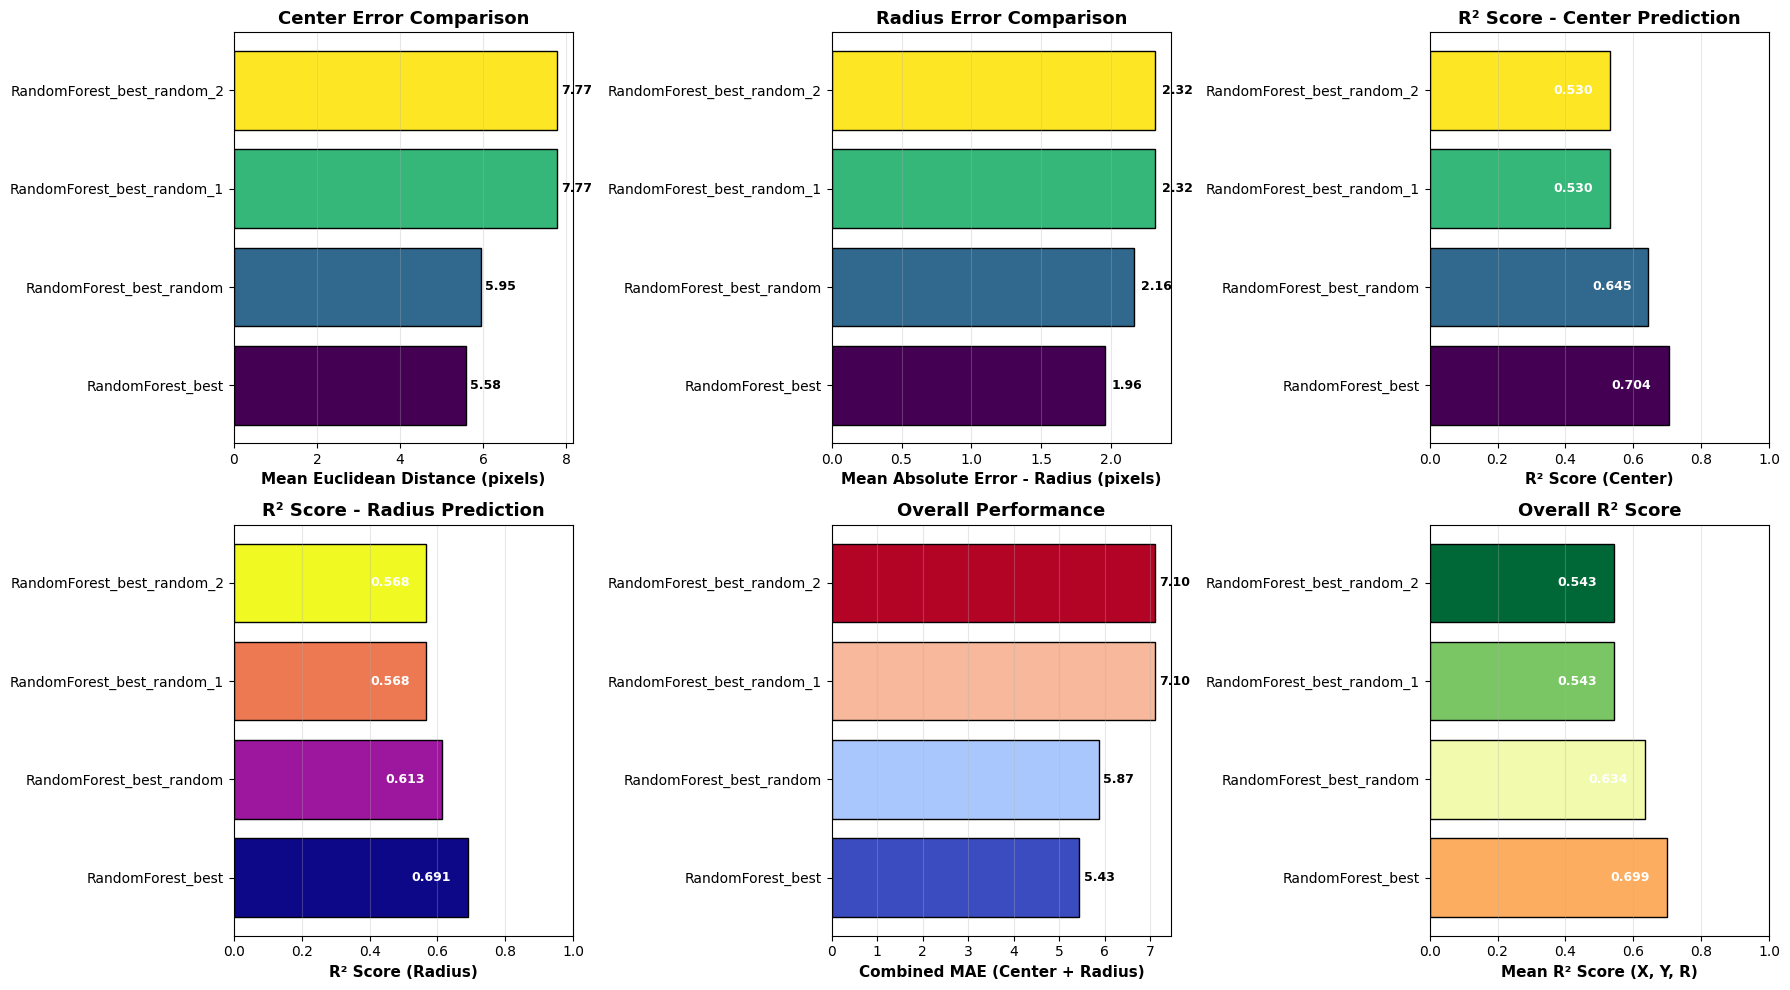

✓ Model comparison charts saved


In [16]:
# ======= Cell 11: Model Comparison Charts =======
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Center Euclidean Distance Comparison
ax1 = axes[0, 0]
models_sorted = results_df.sort_values('euclid_mean')
colors = plt.cm.viridis(np.linspace(0, 1, len(models_sorted)))
bars = ax1.barh(models_sorted['model'], models_sorted['euclid_mean'], color=colors, edgecolor='black')
ax1.set_xlabel('Mean Euclidean Distance (pixels)', fontsize=11, fontweight='bold')
ax1.set_title('Center Error Comparison', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for bar, val in zip(bars, models_sorted['euclid_mean']):
    ax1.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
            va='center', fontsize=9, fontweight='bold')

# 2. Radius MAE Comparison
ax2 = axes[0, 1]
models_sorted_r = results_df.sort_values('mae_r')
bars = ax2.barh(models_sorted_r['model'], models_sorted_r['mae_r'], color=colors, edgecolor='black')
ax2.set_xlabel('Mean Absolute Error - Radius (pixels)', fontsize=11, fontweight='bold')
ax2.set_title('Radius Error Comparison', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for bar, val in zip(bars, models_sorted_r['mae_r']):
    ax2.text(val + 0.05, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
            va='center', fontsize=9, fontweight='bold')

# 3. R² Comparison (Center)
ax3 = axes[0, 2]
models_sorted_r2 = results_df.sort_values('r2_center', ascending=False)
bars = ax3.barh(models_sorted_r2['model'], models_sorted_r2['r2_center'], color=colors, edgecolor='black')
ax3.set_xlabel('R² Score (Center)', fontsize=11, fontweight='bold')
ax3.set_title('R² Score - Center Prediction', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.set_xlim([0, 1])
for bar, val in zip(bars, models_sorted_r2['r2_center']):
    ax3.text(val - 0.05, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', ha='right', fontsize=9, fontweight='bold', color='white')

# 4. R² Comparison (Radius)
ax4 = axes[1, 0]
models_sorted_r2_r = results_df.sort_values('r2_r', ascending=False)
bars = ax4.barh(models_sorted_r2_r['model'], models_sorted_r2_r['r2_r'], 
               color=plt.cm.plasma(np.linspace(0, 1, len(models_sorted_r2_r))), edgecolor='black')
ax4.set_xlabel('R² Score (Radius)', fontsize=11, fontweight='bold')
ax4.set_title('R² Score - Radius Prediction', fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
ax4.set_xlim([0, 1])
for bar, val in zip(bars, models_sorted_r2_r['r2_r']):
    ax4.text(val - 0.05, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', ha='right', fontsize=9, fontweight='bold', color='white')

# 5. Combined Score (Center MAE + Radius MAE)
ax5 = axes[1, 1]
results_df['combined_mae'] = results_df['mae_center'] + results_df['mae_r']
models_sorted_combined = results_df.sort_values('combined_mae')
bars = ax5.barh(models_sorted_combined['model'], models_sorted_combined['combined_mae'], 
               color=plt.cm.coolwarm(np.linspace(0, 1, len(models_sorted_combined))), edgecolor='black')
ax5.set_xlabel('Combined MAE (Center + Radius)', fontsize=11, fontweight='bold')
ax5.set_title('Overall Performance', fontsize=13, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)
for bar, val in zip(bars, models_sorted_combined['combined_mae']):
    ax5.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
            va='center', fontsize=9, fontweight='bold')

# 6. Overall R² Mean
ax6 = axes[1, 2]
models_sorted_overall = results_df.sort_values('r2_mean', ascending=False)
bars = ax6.barh(models_sorted_overall['model'], models_sorted_overall['r2_mean'], 
               color=plt.cm.RdYlGn(np.linspace(0.3, 1, len(models_sorted_overall))), edgecolor='black')
ax6.set_xlabel('Mean R² Score (X, Y, R)', fontsize=11, fontweight='bold')
ax6.set_title('Overall R² Score', fontsize=13, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)
ax6.set_xlim([0, 1])
for bar, val in zip(bars, models_sorted_overall['r2_mean']):
    ax6.text(val - 0.05, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', ha='right', fontsize=9, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'model_comparison_3d.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Model comparison charts saved")

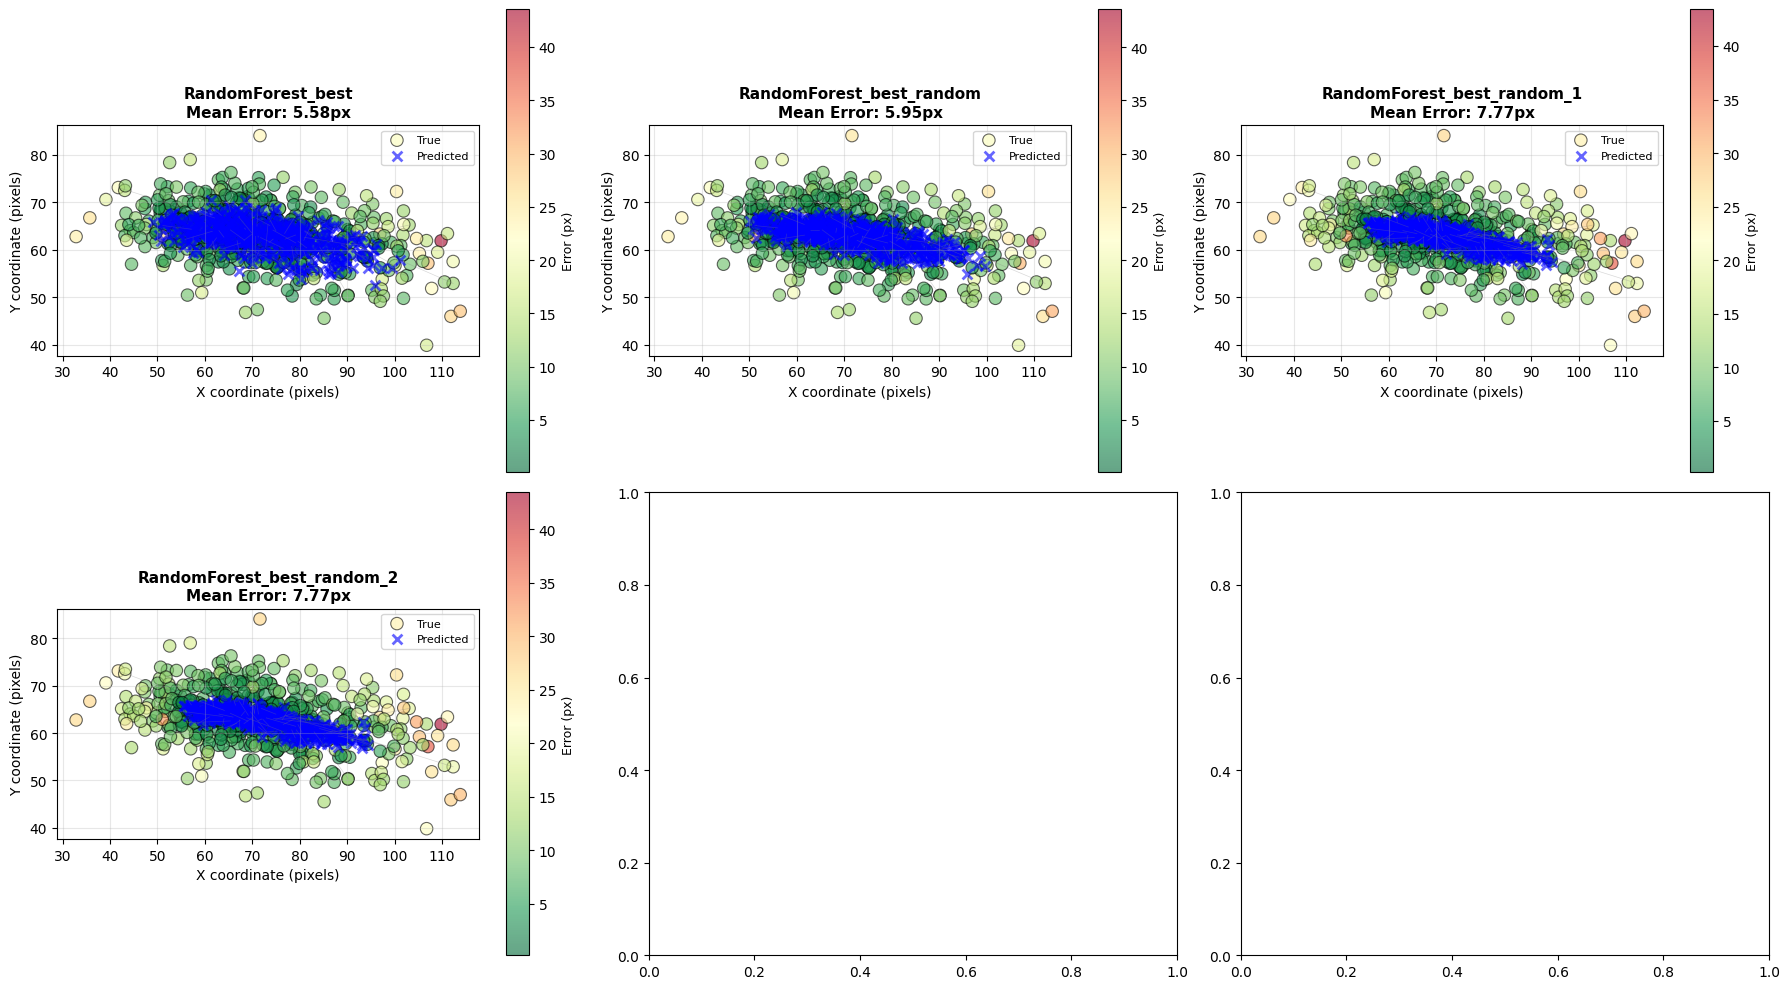

✓ Scatter analysis saved


In [17]:
# ======= Cell 12: Scatter Plot Analysis =======
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, model_name in enumerate(results_df['model'].values):
    y_pred_orig = predictions_dict[model_name]['pred_orig']
    
    # คำนวณ errors
    center_errors = np.sqrt((y_test_orig[:, 0] - y_pred_orig[:, 0])**2 + 
                           (y_test_orig[:, 1] - y_pred_orig[:, 1])**2)
    
    ax = axes[idx // 3, idx % 3]
    
    # Scatter plot ของ center predictions
    scatter = ax.scatter(y_test_orig[:, 0], y_test_orig[:, 1], 
                        c=center_errors, cmap='RdYlGn_r', s=80, alpha=0.6, 
                        edgecolors='black', linewidth=0.8, label='True')
    ax.scatter(y_pred_orig[:, 0], y_pred_orig[:, 1], 
              marker='x', s=50, color='blue', alpha=0.6, linewidth=2, label='Predicted')
    
    # เส้นเชื่อม
    for i in range(min(50, len(y_test_orig))):  # จำกัดจำนวนเส้นเพื่อความชัดเจน
        ax.plot([y_test_orig[i, 0], y_pred_orig[i, 0]], 
               [y_test_orig[i, 1], y_pred_orig[i, 1]], 
               'gray', alpha=0.3, linewidth=0.5)
    
    ax.set_xlabel('X coordinate (pixels)', fontsize=10)
    ax.set_ylabel('Y coordinate (pixels)', fontsize=10)
    ax.set_title(f'{model_name}\nMean Error: {center_errors.mean():.2f}px', 
                fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Error (px)', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'scatter_analysis_3d.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Scatter analysis saved")

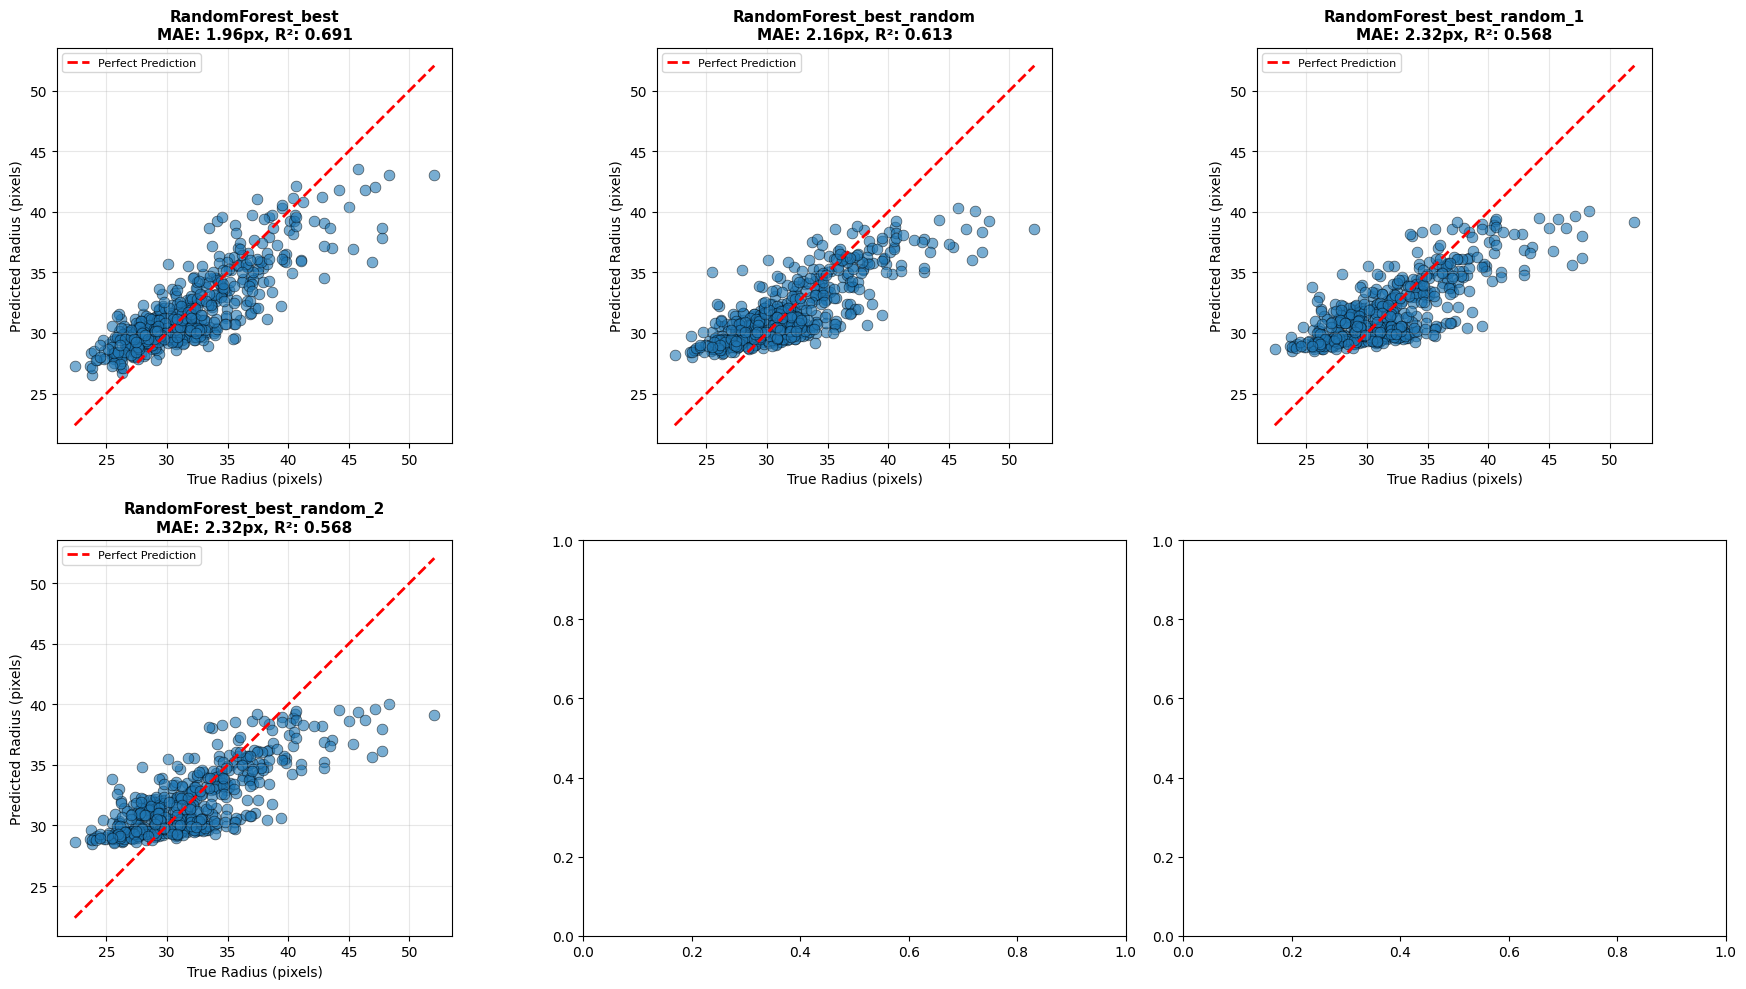

✓ Radius prediction analysis saved


In [18]:
# ======= Cell 13: Radius Prediction Analysis =======
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, model_name in enumerate(results_df['model'].values):
    y_pred_orig = predictions_dict[model_name]['pred_orig']
    
    ax = axes[idx // 3, idx % 3]
    
    # Scatter plot: True vs Predicted Radius
    ax.scatter(y_test_orig[:, 2], y_pred_orig[:, 2], 
              alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_r = min(y_test_orig[:, 2].min(), y_pred_orig[:, 2].min())
    max_r = max(y_test_orig[:, 2].max(), y_pred_orig[:, 2].max())
    ax.plot([min_r, max_r], [min_r, max_r], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Calculate metrics
    mae_r = mean_absolute_error(y_test_orig[:, 2], y_pred_orig[:, 2])
    r2_r = r2_score(y_test_orig[:, 2], y_pred_orig[:, 2])
    
    ax.set_xlabel('True Radius (pixels)', fontsize=10)
    ax.set_ylabel('Predicted Radius (pixels)', fontsize=10)
    ax.set_title(f'{model_name}\nMAE: {mae_r:.2f}px, R²: {r2_r:.3f}', 
                fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'radius_prediction_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Radius prediction analysis saved")

In [21]:
# ======= Cell 14: Best Parameters Summary =======
print("\n📋 BEST PARAMETERS FOR EACH MODEL")
print("="*100)

best_params_list = []
for model_name, results in RandomizedSearchCV.items():
    print(f"\n{model_name}:")
    print("-" * 80)
    for param, value in results['best_params'].items():
        # ลบ prefix ของ pipeline
        clean_param = param.split('__')[-1]
        print(f"  {clean_param:.<50} {value}")
        best_params_list.append({
            'model': model_name,
            'parameter': clean_param,
            'value': str(value)
        })
    print(f"  {'CV Score':..<50} {results['best_score']:.4f}")

# บันทึก best parameters
params_df = pd.DataFrame(best_params_list)
params_path = os.path.join(MODEL_SAVE_DIR, 'best_parameters_3d.csv')
params_df.to_csv(params_path, index=False)
print(f"\n✓ Best parameters saved: {params_path}")


📋 BEST PARAMETERS FOR EACH MODEL

RandomForest_best_random:
--------------------------------------------------------------------------------
  max_depth......................................... None
  max_features...................................... log2
  min_samples_leaf.................................. 1
  min_samples_split................................. 9
  n_estimators...................................... 388
  CV Score.......................................... -9.3970

KNeighbors_best_random:
--------------------------------------------------------------------------------


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
# ======= Cell 15: Detailed Analysis for Best Model =======
best_model = best_models[best_model_name]
y_pred_orig_best = predictions_dict[best_model_name]['pred_orig']

# คำนวณ errors
center_errors = np.sqrt((y_test_orig[:, 0] - y_pred_orig_best[:, 0])**2 + 
                       (y_test_orig[:, 1] - y_pred_orig_best[:, 1])**2)
radius_errors = np.abs(y_test_orig[:, 2] - y_pred_orig_best[:, 2])

print(f"\n🔍 DETAILED ANALYSIS - {best_model_name}")
print("="*100)

print("\n📍 CENTER PREDICTION:")
print(f"  Mean Error: {center_errors.mean():.4f} pixels")
print(f"  Std Dev: {center_errors.std():.4f} pixels")
print(f"  Median Error: {np.median(center_errors):.4f} pixels")
print(f"  Min Error: {center_errors.min():.4f} pixels")
print(f"  Max Error: {center_errors.max():.4f} pixels")
print(f"  25th Percentile: {np.percentile(center_errors, 25):.4f} pixels")
print(f"  75th Percentile: {np.percentile(center_errors, 75):.4f} pixels")
print(f"  95th Percentile: {np.percentile(center_errors, 95):.4f} pixels")

print("\n⭕ RADIUS PREDICTION:")
print(f"  Mean Absolute Error: {radius_errors.mean():.4f} pixels")
print(f"  Std Dev: {radius_errors.std():.4f} pixels")
print(f"  Median Error: {np.median(radius_errors):.4f} pixels")
print(f"  Min Error: {radius_errors.min():.4f} pixels")
print(f"  Max Error: {radius_errors.max():.4f} pixels")
print(f"  25th Percentile: {np.percentile(radius_errors, 25):.4f} pixels")
print(f"  75th Percentile: {np.percentile(radius_errors, 75):.4f} pixels")
print(f"  95th Percentile: {np.percentile(radius_errors, 95):.4f} pixels")

print("\n📊 ACCURACY METRICS:")
# คำนวณเปอร์เซ็นต์ของ predictions ที่มี error ต่ำกว่าขีดจำกัด
thresholds_center = [1, 2, 3, 5, 10]
thresholds_radius = [1, 2, 3, 5]

print("\n  Center Accuracy:")
for thresh in thresholds_center:
    pct = (center_errors < thresh).mean() * 100
    print(f"    < {thresh}px: {pct:.2f}%")

print("\n  Radius Accuracy:")
for thresh in thresholds_radius:
    pct = (radius_errors < thresh).mean() * 100
    print(f"    < {thresh}px: {pct:.2f}%")

print("\n" + "="*100)

In [ ]:
# ======= Cell 16: Export Predictions =======
# สร้าง DataFrame สำหรับ predictions ของโมเดลที่ดีที่สุด
predictions_export = pd.DataFrame({
    'filename': files_test,
    'true_cx': y_test_orig[:, 0],
    'true_cy': y_test_orig[:, 1],
    'true_r': y_test_orig[:, 2],
    'pred_cx': y_pred_orig_best[:, 0],
    'pred_cy': y_pred_orig_best[:, 1],
    'pred_r': y_pred_orig_best[:, 2],
    'error_center': center_errors,
    'error_radius': radius_errors,
    'error_cx': np.abs(y_test_orig[:, 0] - y_pred_orig_best[:, 0]),
    'error_cy': np.abs(y_test_orig[:, 1] - y_pred_orig_best[:, 1])
})

# เรียงตาม error
predictions_export = predictions_export.sort_values('error_center')

# บันทึก
pred_path = os.path.join(MODEL_SAVE_DIR, f'{best_model_name}_predictions.csv')
predictions_export.to_csv(pred_path, index=False)

print(f"✓ Predictions exported to: {pred_path}")
print(f"\nTop 5 Best Predictions:")
print(predictions_export.head()[['filename', 'error_center', 'error_radius']].to_string(index=False))

print(f"\nTop 5 Worst Predictions:")
print(predictions_export.tail()[['filename', 'error_center', 'error_radius']].to_string(index=False))

In [ ]:
# ======= Cell 17: Save All Models Predictions =======
# บันทึก predictions จากทุกโมเดลเพื่อเปรียบเทียบ
all_models_predictions = pd.DataFrame({
    'filename': files_test,
    'true_cx': y_test_orig[:, 0],
    'true_cy': y_test_orig[:, 1],
    'true_r': y_test_orig[:, 2]
})

for model_name in results_df['model'].values:
    y_pred = predictions_dict[model_name]['pred_orig']
    all_models_predictions[f'{model_name}_cx'] = y_pred[:, 0]
    all_models_predictions[f'{model_name}_cy'] = y_pred[:, 1]
    all_models_predictions[f'{model_name}_r'] = y_pred[:, 2]
    
    # คำนวณ errors
    center_err = np.sqrt((y_test_orig[:, 0] - y_pred[:, 0])**2 + 
                        (y_test_orig[:, 1] - y_pred[:, 1])**2)
    radius_err = np.abs(y_test_orig[:, 2] - y_pred[:, 2])
    
    all_models_predictions[f'{model_name}_error_center'] = center_err
    all_models_predictions[f'{model_name}_error_radius'] = radius_err

all_pred_path = os.path.join(MODEL_SAVE_DIR, 'all_models_predictions.csv')
all_models_predictions.to_csv(all_pred_path, index=False)

print(f"✓ All models predictions saved to: {all_pred_path}")

In [ ]:
# ======= Cell 18: Create Summary Report =======
summary_report = f"""
{'='*100}
EYE CENTER + RADIUS DETECTION - GRID SEARCH RESULTS
{'='*100}

DATASET INFORMATION:
  - Total Samples: {len(X)}
  - Training Samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)
  - Test Samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)
  - Image Size: {RESIZED[0]}x{RESIZED[1]} pixels
  - Feature Dimension: {X.shape[1]} (HOG features)
  - Target Variables: 3 (cx, cy, radius)

BEST MODEL: {best_model_name}
{'='*100}

CENTER PREDICTION PERFORMANCE:
  - Mean Euclidean Distance: {best_metrics['euclid_mean']:.4f} ± {best_metrics['euclid_std']:.4f} pixels
  - Median Error: {best_metrics['euclid_median']:.4f} pixels
  - Maximum Error: {best_metrics['euclid_max']:.4f} pixels
  - MAE (X, Y): {best_metrics['mae_x']:.4f}, {best_metrics['mae_y']:.4f} pixels
  - R² Score: {best_metrics['r2_center']:.4f}

RADIUS PREDICTION PERFORMANCE:
  - Mean Absolute Error: {best_metrics['mae_r']:.4f} pixels
  - RMSE: {best_metrics['rmse_r']:.4f} pixels
  - R² Score: {best_metrics['r2_r']:.4f}

OVERALL PERFORMANCE:
  - Mean R² Score: {best_metrics['r2_mean']:.4f}
  - Cross-Validation Score: {best_metrics['cv_score']:.4f}

{'='*100}
ALL MODELS RANKING (by Center Error):
{'='*100}

"""

for i, row in results_df.iterrows():
    summary_report += f"""
{row['model']:20s} | Center: {row['euclid_mean']:6.3f}±{row['euclid_std']:5.3f}px | Radius: {row['mae_r']:6.3f}px | R²: {row['r2_mean']:.3f}
"""

summary_report += f"""
{'='*100}

FILES SAVED:
  - Models: {MODEL_SAVE_DIR}/[ModelName]_best.joblib
  - Results: {MODEL_SAVE_DIR}/grid_search_results_3d.csv
  - Parameters: {MODEL_SAVE_DIR}/best_parameters_3d.csv
  - Predictions: {MODEL_SAVE_DIR}/{best_model_name}_predictions.csv
  - All Predictions: {MODEL_SAVE_DIR}/all_models_predictions.csv
  - Visualizations: {MODEL_SAVE_DIR}/*.png

{'='*100}
"""

# บันทึก report
report_path = os.path.join(MODEL_SAVE_DIR, 'SUMMARY_REPORT.txt')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(summary_report)
print(f"\n✓ Summary report saved to: {report_path}")

In [ ]:
# ======= Cell 19: Function to Load and Use Best Model =======
def load_and_predict(image_path, model_path=None):
    """
    ฟังก์ชันสำหรับโหลดโมเดลและทำนายจุดกลางตา + radius
    
    Parameters:
    -----------
    image_path : str
        path ของภาพที่ต้องการทำนาย
    model_path : str, optional
        path ของโมเดล (ถ้าไม่ระบุจะใช้โมเดลที่ดีที่สุด)
    
    Returns:
    --------
    tuple : (cx, cy, radius, visualization_image)
    """
    if model_path is None:
        model_path = os.path.join(MODEL_SAVE_DIR, f"{best_model_name}_best.joblib")
    
    # โหลดโมเดล
    model = joblib.load(model_path)
    
    # โหลดภาพ
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {image_path}")
    
    h, w = img.shape[:2]
    
    # Preprocessing
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img)
    
    # Resize และ extract features
    img_resized = cv2.resize(img_enhanced, RESIZED)
    features = hog(img_resized, 
                  orientations=9,
                  pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2),
                  feature_vector=True,
                  block_norm='L2-Hys')
    
    # Predict
    pred_resized = model.predict(features.reshape(1, -1))[0]
    
    # Scale back to original size
    scale_x_back = w / float(RESIZED[0])
    scale_y_back = h / float(RESIZED[1])
    scale_r_back = (scale_x_back + scale_y_back) / 2.0
    
    cx = pred_resized[0] * scale_x_back
    cy = pred_resized[1] * scale_y_back
    radius = pred_resized[2] * scale_r_back
    
    # สร้างภาพสำหรับแสดงผล
    vis_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.circle(vis_img, (int(cx), int(cy)), int(radius), (0, 255, 0), 2)
    cv2.circle(vis_img, (int(cx), int(cy)), 3, (0, 0, 255), -1)
    cv2.putText(vis_img, f"Center: ({cx:.1f}, {cy:.1f})", 
               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(vis_img, f"Radius: {radius:.1f}px", 
               (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    
    return cx, cy, radius, vis_img


# ตัวอย่างการใช้งาน
print("\n💡 USAGE EXAMPLE:")
print("="*80)
print("""
# โหลดและทำนาย
from your_module import load_and_predict

cx, cy, radius, vis_img = load_and_predict('path/to/your/image.png')

print(f"Center: ({cx:.2f}, {cy:.2f})")
print(f"Radius: {radius:.2f} pixels")

# แสดงผล
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# หรือบันทึกภาพ
cv2.imwrite('result.png', vis_img)
""")
print("="*80)

print(f"\n✅ Training completed successfully!")
print(f"📁 All results saved in: {MODEL_SAVE_DIR}")
print(f"🏆 Best model: {best_model_name}")

In [ ]:
# ======= Cell 20: Test the Prediction Function =======
# ทดสอบฟังก์ชัน load_and_predict กับภาพจาก test set
print("\n🧪 Testing prediction function with random test samples...")

# เลือกภาพสุ่ม 6 ภาพจาก test set
n_test_samples = min(6, len(idx_test))
random_test_idx = random.sample(range(len(idx_test)), n_test_samples)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, test_idx in enumerate(random_test_idx):
    orig_idx = idx_test[test_idx]
    filename = filenames[orig_idx]
    img_path = os.path.join(IMG_DIR, filename)
    
    # ทำนาย
    try:
        cx, cy, radius, vis_img = load_and_predict(img_path)
        
        # Ground truth
        gt_cx, gt_cy, gt_r = y_test_orig[test_idx]
        
        # คำนวณ error
        center_error = np.sqrt((cx - gt_cx)**2 + (cy - gt_cy)**2)
        radius_error = abs(radius - gt_r)
        
        # แสดงผล
        ax = axes[i]
        ax.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        ax.set_title(f'{filename[:25]}\nCenter Err: {center_error:.2f}px, Radius Err: {radius_error:.2f}px', 
                    fontsize=9)
        ax.axis('off')
        
        # เพิ่ม ground truth (วงกลมสีเหลือง)
        circle_gt = plt.Circle((gt_cx, gt_cy), gt_r, color='yellow', 
                              fill=False, linewidth=2, linestyle='--', alpha=0.7)
        ax.add_patch(circle_gt)
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center')
        ax.axis('off')

plt.suptitle(f'Prediction Test - {best_model_name} (Green: Prediction, Yellow: Ground Truth)', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'prediction_function_test.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Prediction function test completed")
print(f"\n🎉 ALL TASKS COMPLETED!")